# BGE-M3 ONNX Performance Analysis

> **⚠️ Important Disclaimer**: If you have PyTorch installed with CUDA support (e.g., installed via `pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu[version]`), the FlagEmbedding library will silently use CUDA for embedding generation instead of CPU. This benchmark specifically tests FlagEmbedding in CPU-only mode. Please ensure that your FlagEmbedding implementation is using CPU for accurate comparison with the results presented here.

This notebook analyzes performance test results for BGE-M3 ONNX implementation across different programming languages (Python, C#/.NET, Java) and execution providers (CPU, CUDA).

## System Specifications

- **Operating System**: Windows 11 Pro 64-bit (10.0, Build 26100)
- **System Manufacturer**: Gigabyte Technology Co., Ltd. B650 AERO G
- **CPU**: AMD Ryzen 7 7800X3D 8-Core Processor
- **GPU**: NVIDIA GeForce RTX 4080 SUPER
- **RAM**: G. Skill Trident Z5 Neo 32768MB RAM

## Library Versions

- **Python**: onnxruntime-gpu[cuda,cudnn]: 1.22.0, onnxruntime_extensions: 0.14.0, FlagEmbedding 1.3.4
- **C#/.NET**: Microsoft.ML.OnnxRuntime.Gpu: 1.22.0, Microsoft.ML.OnnxRuntime.Extensions: 0.14.0
- **Java**: onnxruntime_gpu: 1.22.0, onnxruntime-extensions: 0.13.0

## Test Dataset

All tests were performed on a dataset of 1000 diverse texts with varying lengths, languages, and domains.

In [11]:
%pip install matplotlib seaborn pandas numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: C:\Users\siwi1\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_performance_data():
    results = {}
    
    files = {
        'Python': 'onnx/performance_python.json',
        'C#/.NET': 'onnx/performance_dotnet.json', 
        'Java': 'onnx/performance_java.json'
    }
    
    for lang, filepath in files.items():
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
                results[lang] = data
                print(f"Loaded {lang} results from {filepath}")
        except FileNotFoundError:
            print(f"Could not find {filepath}")
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    
    return results

performance_data = load_performance_data()

Loaded Python results from onnx/performance_python.json
Loaded C#/.NET results from onnx/performance_dotnet.json
Loaded Java results from onnx/performance_java.json


In [13]:
# Extract performance metrics for visualization
def extract_metrics(data):
    metrics = []
    
    for language, lang_data in data.items():
        scenarios = lang_data.get('scenarios', {})
        
        for scenario_name, scenario_data in scenarios.items():
            if scenario_data.get('error'):
                continue
                
            provider = 'CUDA' if 'cuda' in scenario_name.lower() else 'CPU'
            
            if 'flagembedding' in scenario_name:
                impl_type = 'FlagEmbedding'
            else:
                impl_type = 'ONNX'
            
            metrics.append({
                'Language': language,
                'Provider': provider,
                'Implementation': impl_type,
                'Scenario': scenario_name,
                'Avg_Latency_ms': scenario_data.get('average_latency_ms', 0),
                'Throughput_texts_per_sec': scenario_data.get('throughput_texts_per_second', 0),
                'Init_Time_sec': scenario_data.get('initialization_time_seconds', 0),
                'Total_Time_sec': scenario_data.get('total_time_seconds', 0),
                'Successful_Embeddings': scenario_data.get('successful_embeddings', 0)
            })
    
    return pd.DataFrame(metrics)

df = extract_metrics(performance_data)
print(f"\nExtracted {len(df)} performance measurements:")
print(df[['Language', 'Provider', 'Implementation', 'Avg_Latency_ms', 'Throughput_texts_per_sec']].to_string(index=False))


Extracted 7 performance measurements:
Language Provider Implementation  Avg_Latency_ms  Throughput_texts_per_sec
  Python      CPU  FlagEmbedding      128.046977                  7.809309
  Python      CPU           ONNX       32.367453                 30.893321
  Python     CUDA           ONNX        7.071363                141.103350
 C#/.NET      CPU           ONNX       32.167672                 31.083134
 C#/.NET     CUDA           ONNX        7.462482                133.977178
    Java     CUDA           ONNX        7.095000                140.944327
    Java      CPU           ONNX       32.057000                 31.194435


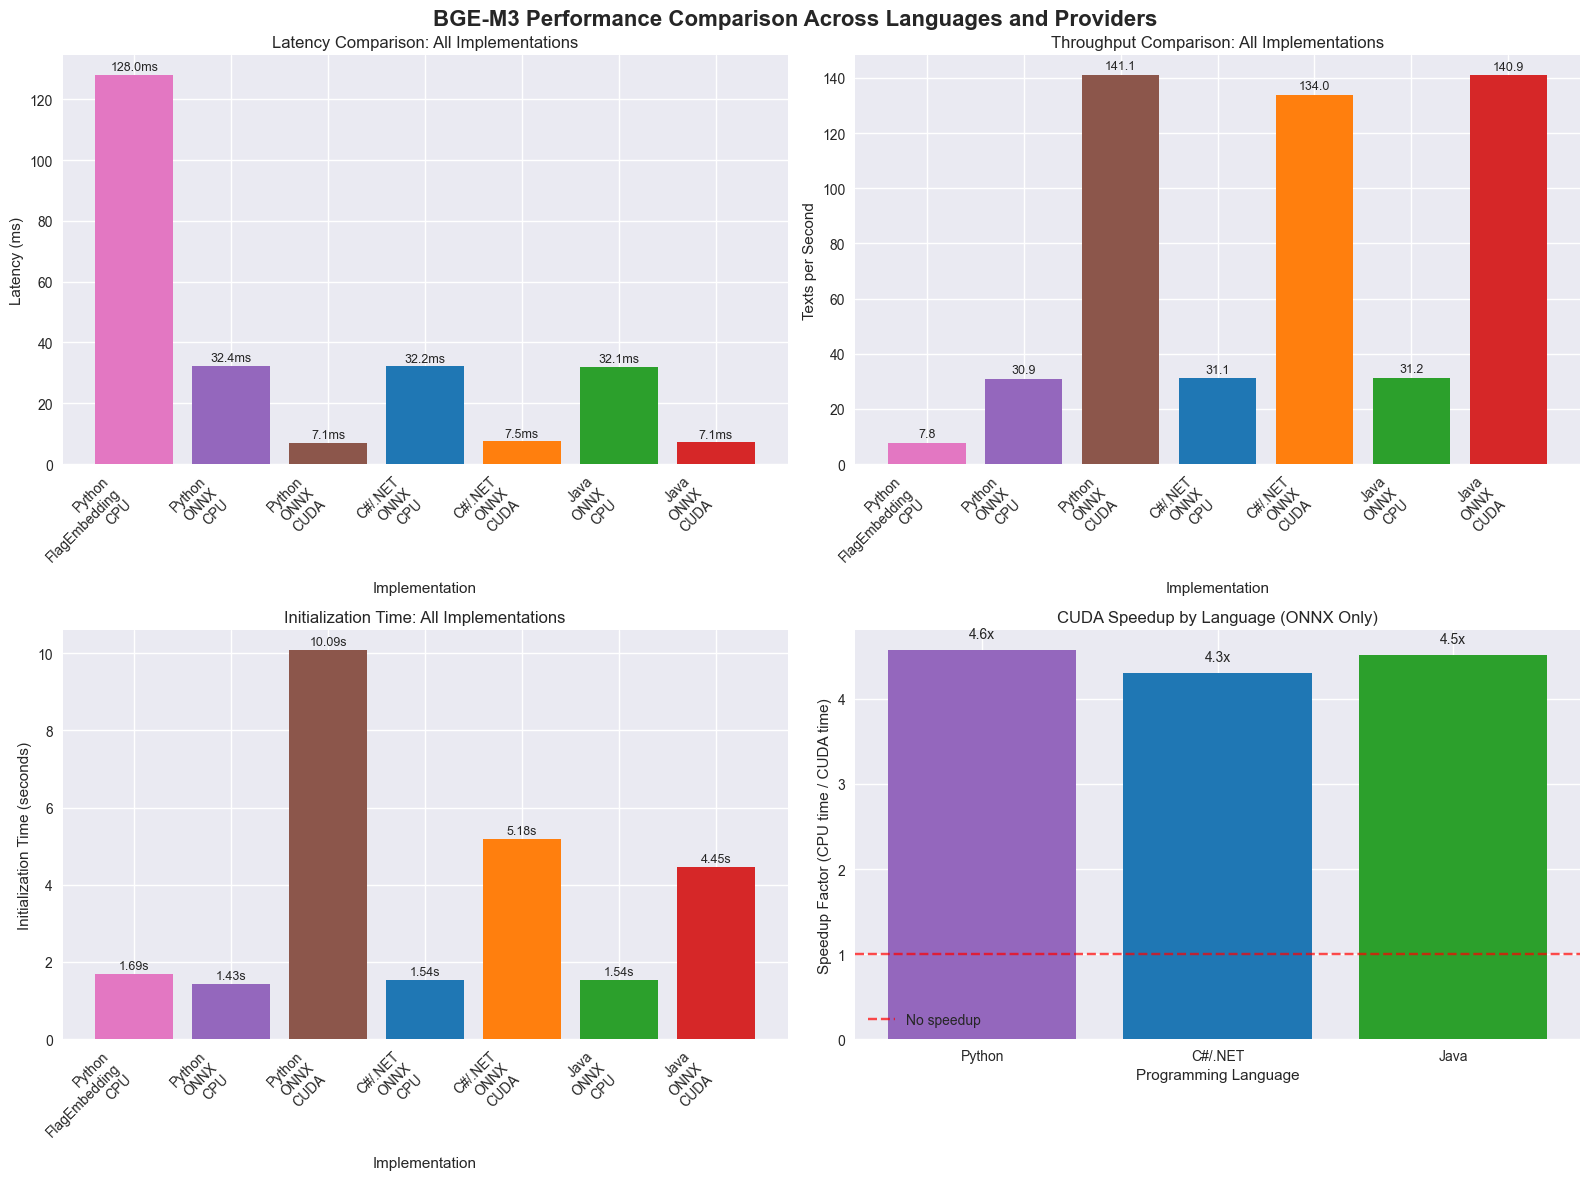

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('BGE-M3 Performance Comparison Across Languages and Providers', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]

ordered_implementations = [
   'Python_FlagEmbedding_CPU',
   'Python_ONNX_CPU', 
   'Python_ONNX_CUDA',
   'C#/.NET_ONNX_CPU',
   'C#/.NET_ONNX_CUDA', 
   'Java_ONNX_CPU',
   'Java_ONNX_CUDA'
]

color_map = {
   'Python_FlagEmbedding_CPU': '#e377c2',
   'Python_ONNX_CPU': '#9467bd',
   'Python_ONNX_CUDA': '#8c564b',
   'C#/.NET_ONNX_CPU': '#1f77b4',
   'C#/.NET_ONNX_CUDA': '#ff7f0e', 
   'Java_ONNX_CPU': '#2ca02c',
   'Java_ONNX_CUDA': '#d62728'
}

data_mapping = {}
for _, row in df.iterrows():
   if row['Implementation'] == 'ONNX':
       key = f"{row['Language']}_ONNX_{row['Provider']}"
   else:
       key = f"{row['Language']}_FlagEmbedding_{row['Provider']}"
   data_mapping[key] = row['Avg_Latency_ms']

ordered_latencies = []
ordered_colors = []
display_labels = []

for impl in ordered_implementations:
   if impl in data_mapping:
       ordered_latencies.append(data_mapping[impl])
       ordered_colors.append(color_map[impl])
       display_labels.append(impl.replace('_', '\n'))

bars1 = ax1.bar(range(len(display_labels)), ordered_latencies, color=ordered_colors)
ax1.set_title('Latency Comparison: All Implementations')
ax1.set_ylabel('Latency (ms)')
ax1.set_xlabel('Implementation')
ax1.set_xticks(range(len(display_labels)))
ax1.set_xticklabels(display_labels, rotation=45, ha='right')

for bar, latency in zip(bars1, ordered_latencies):
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{latency:.1f}ms', ha='center', va='bottom', fontsize=9)

ax2 = axes[0, 1]

throughput_mapping = {}
for _, row in df.iterrows():
   if row['Implementation'] == 'ONNX':
       key = f"{row['Language']}_ONNX_{row['Provider']}"
   else:
       key = f"{row['Language']}_FlagEmbedding_{row['Provider']}"
   throughput_mapping[key] = row['Throughput_texts_per_sec']

ordered_throughput = []
for impl in ordered_implementations:
   if impl in throughput_mapping:
       ordered_throughput.append(throughput_mapping[impl])

bars2 = ax2.bar(range(len(display_labels)), ordered_throughput, color=ordered_colors)
ax2.set_title('Throughput Comparison: All Implementations')
ax2.set_ylabel('Texts per Second')
ax2.set_xlabel('Implementation')
ax2.set_xticks(range(len(display_labels)))
ax2.set_xticklabels(display_labels, rotation=45, ha='right')

for bar, throughput in zip(bars2, ordered_throughput):
   height = bar.get_height()
   ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{throughput:.1f}', ha='center', va='bottom', fontsize=9)

ax3 = axes[1, 0]

init_mapping = {}
for _, row in df.iterrows():
   if row['Implementation'] == 'ONNX':
       key = f"{row['Language']}_ONNX_{row['Provider']}"
   else:
       key = f"{row['Language']}_FlagEmbedding_{row['Provider']}"
   init_mapping[key] = row['Init_Time_sec']

ordered_init = []
for impl in ordered_implementations:
   if impl in init_mapping:
       ordered_init.append(init_mapping[impl])

bars3 = ax3.bar(range(len(display_labels)), ordered_init, color=ordered_colors)
ax3.set_title('Initialization Time: All Implementations')
ax3.set_ylabel('Initialization Time (seconds)')
ax3.set_xlabel('Implementation')
ax3.set_xticks(range(len(display_labels)))
ax3.set_xticklabels(display_labels, rotation=45, ha='right')

for bar, init_time in zip(bars3, ordered_init):
   height = bar.get_height()
   ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{init_time:.2f}s', ha='center', va='bottom', fontsize=9)

ax4 = axes[1, 1]

speedup_data = []
speedup_colors = []

for lang in ['Python', 'C#/.NET', 'Java']:
   lang_onnx_df = df[(df['Language'] == lang) & (df['Implementation'] == 'ONNX')]
   cpu_latency = lang_onnx_df[lang_onnx_df['Provider'] == 'CPU']['Avg_Latency_ms'].values
   cuda_latency = lang_onnx_df[lang_onnx_df['Provider'] == 'CUDA']['Avg_Latency_ms'].values
   
   if len(cpu_latency) > 0 and len(cuda_latency) > 0 and cuda_latency[0] > 0:
       speedup = cpu_latency[0] / cuda_latency[0]
       speedup_data.append(speedup)
       
       if lang == 'Python':
           speedup_colors.append('#9467bd')
       elif lang == 'C#/.NET':
           speedup_colors.append('#1f77b4')
       elif lang == 'Java':
           speedup_colors.append('#2ca02c')

if speedup_data:
   language_labels = ['Python', 'C#/.NET', 'Java'][:len(speedup_data)]
   bars4 = ax4.bar(language_labels, speedup_data, color=speedup_colors)
   ax4.set_title('CUDA Speedup by Language (ONNX Only)')
   ax4.set_ylabel('Speedup Factor (CPU time / CUDA time)')
   ax4.set_xlabel('Programming Language')
   ax4.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
   ax4.legend()
   
   for bar in bars4:
       height = bar.get_height()
       ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
               f'{height:.1f}x', ha='center', va='bottom', fontsize=10)
else:
   ax4.text(0.5, 0.5, 'No CUDA speedup data available', 
            ha='center', va='center', transform=ax4.transAxes)
   ax4.set_title('CUDA Speedup by Language (No Data)')

plt.tight_layout()
plt.show()

In [15]:
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)

summary_df = df.copy()
summary_df['Latency (ms)'] = summary_df['Avg_Latency_ms'].round(1)
summary_df['Throughput (texts/sec)'] = summary_df['Throughput_texts_per_sec'].round(1)
summary_df['Init Time (sec)'] = summary_df['Init_Time_sec'].round(2)

display_cols = ['Language', 'Provider', 'Implementation', 'Latency (ms)', 'Throughput (texts/sec)', 'Init Time (sec)']
print(summary_df[display_cols].to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

if not df.empty:
    best_latency = df.loc[df['Avg_Latency_ms'].idxmin()]
    best_throughput = df.loc[df['Throughput_texts_per_sec'].idxmax()]
    
    print(f"⚡ Lowest Latency: {best_latency['Language']} {best_latency['Provider']} ({best_latency['Avg_Latency_ms']:.1f}ms)")
    print(f"🚀 Highest Throughput: {best_throughput['Language']} {best_throughput['Provider']} ({best_throughput['Throughput_texts_per_sec']:.1f} texts/sec)")
    
    cuda_results = df[df['Provider'] == 'CUDA']
    cpu_results = df[df['Provider'] == 'CPU']
    
    if not cuda_results.empty and not cpu_results.empty:
        avg_cuda_latency = cuda_results['Avg_Latency_ms'].mean()
        avg_cpu_latency = cpu_results['Avg_Latency_ms'].mean()
        overall_speedup = avg_cpu_latency / avg_cuda_latency if avg_cuda_latency > 0 else 0
        
        print(f"📊 Average CUDA Speedup: {overall_speedup:.1f}x faster than CPU")
        print(f"💾 CPU Average Latency: {avg_cpu_latency:.1f}ms")
        print(f"⚡ CUDA Average Latency: {avg_cuda_latency:.1f}ms")
else:
    print("No performance data available for analysis.")


PERFORMANCE SUMMARY
Language Provider Implementation  Latency (ms)  Throughput (texts/sec)  Init Time (sec)
  Python      CPU  FlagEmbedding         128.0                     7.8             1.69
  Python      CPU           ONNX          32.4                    30.9             1.43
  Python     CUDA           ONNX           7.1                   141.1            10.09
 C#/.NET      CPU           ONNX          32.2                    31.1             1.54
 C#/.NET     CUDA           ONNX           7.5                   134.0             5.18
    Java     CUDA           ONNX           7.1                   140.9             4.45
    Java      CPU           ONNX          32.1                    31.2             1.54

KEY INSIGHTS
⚡ Lowest Latency: Python CUDA (7.1ms)
🚀 Highest Throughput: Python CUDA (141.1 texts/sec)
📊 Average CUDA Speedup: 7.8x faster than CPU
💾 CPU Average Latency: 56.2ms
⚡ CUDA Average Latency: 7.2ms


## Conclusion

The performance evaluation reveals no meaningful differences between C#/.NET, Python, and Java ONNX implementations. Observed variations represent statistical measurement error rather than actual performance differences. This is expected since model inference occurs within ONNX Runtime, making the host programming language irrelevant for computational performance.

CUDA acceleration provides consistent 4.3-4.6x speedup across all languages, confirming uniform GPU acceleration benefits.

ONNX CPU (~32.2 ms) outperforms Python FlagEmbedding CPU (128.0ms) by approximately 4 times. ONNX runtime inference delivers significantly better CPU performance than FlagEmbedding's implementation.

### Technical Notes

- All tests performed on the same hardware configuration
- Results based on 1000 diverse text samples
- Measurements include model initialization and inference times
- Library version and execution providers may affect results